# Predicting the average selling price in the oil gas sector

This notebook is a mix of data exploration together with ARIMA models to predict prices from product temporal series

## 1) Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

## 2) Data loading

In [2]:
def load_data(path):
    '''
    This function returns the data set

    -----------
    Parameters
    -----------
    
    path : string
        Directory and name of the file

    -----------
    Returns
    -----------

    df : pandas dataframe
        Dataframe with the data
    '''
    
    df = pd.read_parquet(path)
    
    return df

In [3]:
df = load_data('data/oil_and_gas_dataset.parquet')
df.shape

(556501, 11)

## 3) Data pre-process

The first look at the data:

In [4]:
df.head()

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
0,White Label,BA,Bahia,2917607,Jaguaquara,Gasolina,R$/litro,5,1.723251,2.030526,2004-05-01
1,Blue Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,33,1.225628,1.397636,2004-05-01
2,Green Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,128,1.224991,1.415282,2004-05-01
3,Green Label,SP,São Paulo,3505708,Barueri,Etanol,R$/litro,5,0.619567,0.856467,2004-05-01
4,White Label,SP,São Paulo,3513009,Cotia,Etanol,R$/litro,21,0.604228,0.804345,2004-05-01


In [5]:
df.tail()

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
556496,Blue Label,MA,Maranhão,2111300,São Luís,Gasolina,R$/litro,4,NaN,5.836667,2024-08-01
556497,Blue Label,PA,Pará,1506807,Santarém,Diesel,R$/litro,6,NaN,6.234545,2024-08-01
556498,Purple Label,SP,São Paulo,3526902,Limeira,Diesel,R$/litro,4,NaN,6.006000,2024-08-01
556499,Purple Label,SP,São Paulo,3518800,Guarulhos,Diesel,R$/litro,1,NaN,6.040000,2024-08-01
556500,White Label,PB,Paraíba,2503209,Cabedelo,Etanol,R$/litro,4,NaN,4.753750,2024-08-01


In [6]:
df.describe()

,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
count,556501.000000,331360.000000,556501.000000,556501
mean,6.343187,2.278602,3.270554,2015-04-05 23:16:10.432758016
min,1.000000,0.413200,0.668744,2004-05-01 00:00:00
25%,2.000000,1.746553,2.205714,2010-07-01 00:00:00
50%,3.000000,2.190800,2.894286,2015-07-01 00:00:00
75%,6.000000,2.649900,3.967500,2020-03-01 00:00:00
max,1096.000000,4.747100,8.990000,2024-08-01 00:00:00
std,15.529743,0.713028,1.390611,NaN


In [7]:
df.shape

(556501, 11)

Removing `avg_preco_compra` due to its huge sequence of NaN values and because this is essentially the quantity to be predicted:

In [8]:
df = df.drop('avg_preco_compra', axis = 1)
df.shape

(556501, 10)

Getting information about column names and types:

In [9]:
columns = df.columns.tolist()
columns

['bandeira_revenda_cat',
 'sigla_uf',
 'sigla_uf_nome',
 'id_municipio',
 'id_municipio_nome',
 'produto',
 'unidade_medida',
 'n_estabelecimentos',
 'avg_preco_venda',
 'data']

In [10]:
types = df.dtypes.to_dict()
types

{'bandeira_revenda_cat': dtype('O'),
 'sigla_uf': dtype('O'),
 'sigla_uf_nome': dtype('O'),
 'id_municipio': dtype('O'),
 'id_municipio_nome': dtype('O'),
 'produto': dtype('O'),
 'unidade_medida': dtype('O'),
 'n_estabelecimentos': dtype('int64'),
 'avg_preco_venda': dtype('float64'),
 'data': dtype('<M8[ns]')}

Pre-processing the data:

In [11]:
def data_prep(df):
    '''
    This function is responsible for:
        1) Sample the data set
        2) Remove nan values
        3) Tranform categorical into numerical information 
        4) Removing columns with unique values
        5) Tranforming skewed and wide range variable distributions
        6) Sorting by data
        7) Removing "duplicate" information (similar variables)

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe with the whole data

    -----------
    Returns
    -----------

    df : pandas dataframe
        The modified dataframe
    '''

    #1) Sampling the data set
    df = df.sample(frac = 1)

    #2) Removing nan values
    df = df.dropna()

    #3) Transforming categorical to numerical information
    LE = LabelEncoder()
    for i in range(len(columns)):
        if types[columns[i]] == 'object':
            df[columns[i]] = LE.fit_transform(df[columns[i]])
        
    #4) Removing columns with unique values
    for i in range(len(columns)):
        if df[columns[i]].unique().shape[0] == 1:
            df = df.drop(columns[i], axis = 1)

    #5) Tranforming skewed and wide range variable distributions
    df['n_estabelecimentos'] = np.log10(df['n_estabelecimentos'])

    #6) Sorting by data
    df = df.sort_values(by = 'data')

    #7) Removing "duplicate" information (similar variables)
    df = df.drop('sigla_uf_nome', axis = 1)
    df = df.drop('id_municipio_nome', axis = 1)

    return df

In [12]:
df.shape

(556501, 10)

In [13]:
df = data_prep(df)
df.shape

(556498, 7)

Getting the new columns and types:

In [14]:
columns = df.columns.tolist()

In [15]:
types = df.dtypes.to_dict()

Taking a look at how the data looks like:

array([[<Axes: title={'center': 'bandeira_revenda_cat'}>,
        <Axes: title={'center': 'sigla_uf'}>,
        <Axes: title={'center': 'id_municipio'}>],
       [<Axes: title={'center': 'produto'}>,
        <Axes: title={'center': 'n_estabelecimentos'}>,
        <Axes: title={'center': 'avg_preco_venda'}>],
       [<Axes: title={'center': 'data'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

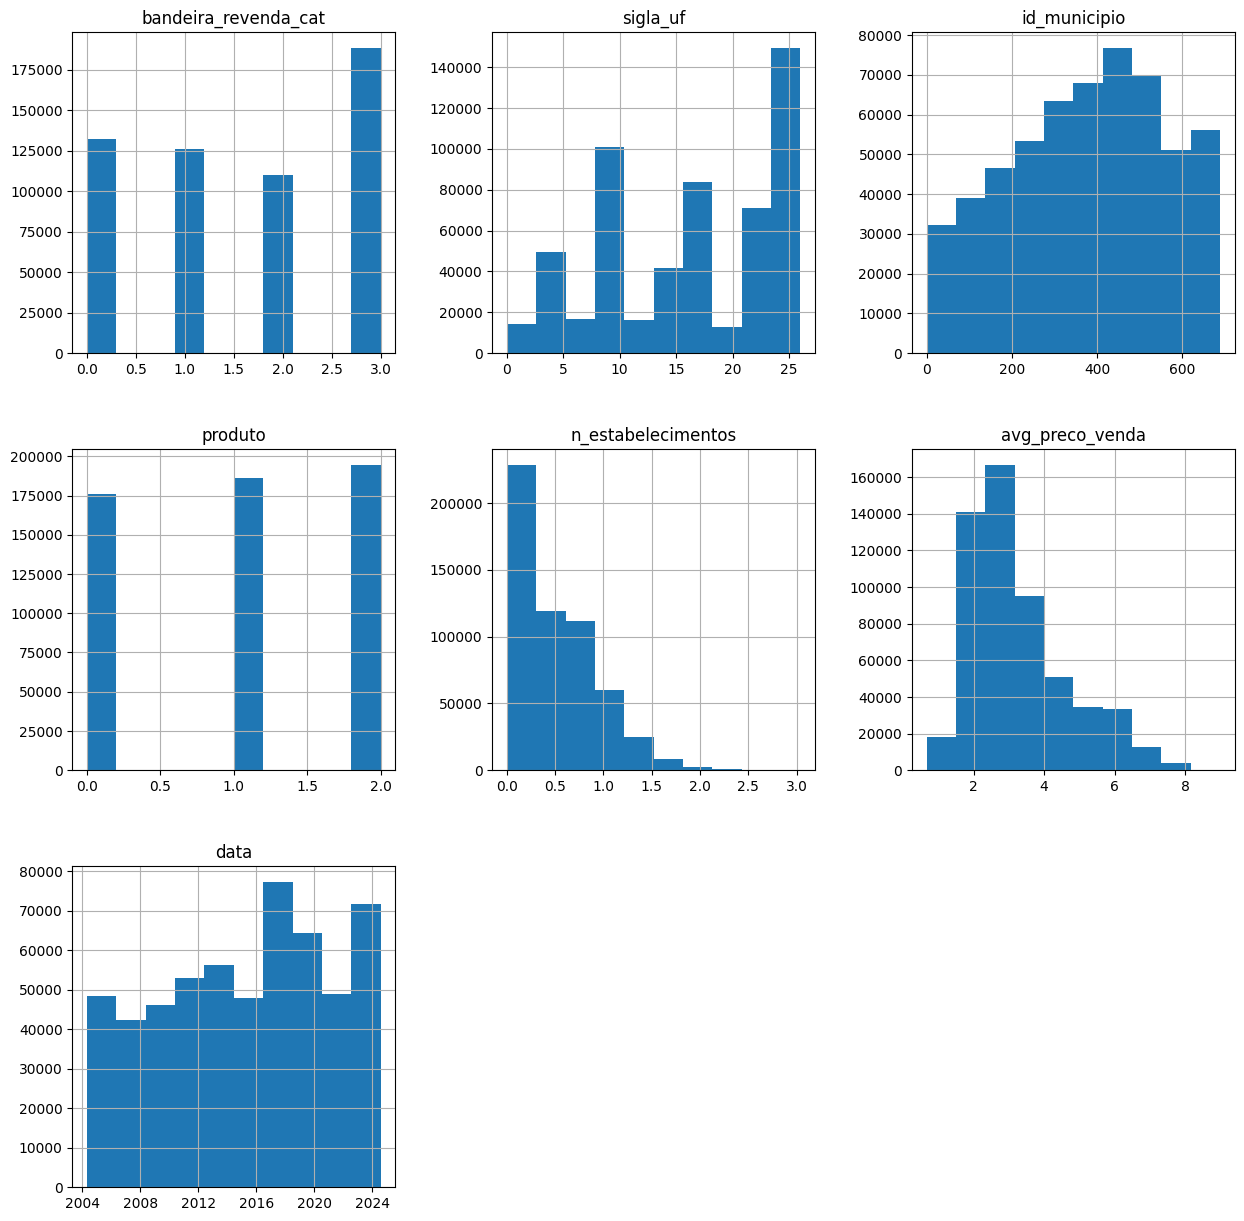

In [16]:
plt.figure(dpi = 100)
df.hist(bins = 10, figsize = (15, 15))

A bit about the statistics of the dataset:

In [17]:
df.describe()

,bandeira_revenda_cat,sigla_uf,id_municipio,produto,n_estabelecimentos,avg_preco_venda,data
count,556498.000000,556498.000000,556498.000000,556498.000000,556498.000000,556498.000000,556498
mean,1.637731,16.384395,374.636841,1.033837,0.534698,3.270557,2015-04-05 23:20:37.149459712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.668744,2004-05-01 00:00:00
25%,1.000000,10.000000,235.000000,0.000000,0.301030,2.205714,2010-07-01 00:00:00
50%,2.000000,17.000000,389.000000,1.000000,0.477121,2.894286,2015-07-01 00:00:00
75%,3.000000,25.000000,514.000000,2.000000,0.778151,3.967500,2020-03-01 00:00:00
max,3.000000,26.000000,689.000000,2.000000,3.039811,8.990000,2024-08-01 00:00:00
std,1.176322,7.527048,182.164206,0.815343,0.430491,1.390614,NaN


Getting data per product:

In [18]:
def data_per_product(df):
    '''
    This function is responsible for:
        1) Creating a dataframe per product
        2) Creating new variables

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe with the whole data

    -----------
    Returns
    -----------

    df : pandas dataframe
        The modified dataframe
    '''

    #1) Creating a dataframe per product
    df_0 = df[df['produto'] == 0]
    df_1 = df[df['produto'] == 1]
    df_2 = df[df['produto'] == 2]

    #2) Grouping the average price by data per product
    new_df_0 = df_0.groupby('data')['avg_preco_venda'].mean().reset_index()
    new_df_1 = df_1.groupby('data')['avg_preco_venda'].mean().reset_index()
    new_df_2 = df_2.groupby('data')['avg_preco_venda'].mean().reset_index()

    #3) Creating new variables
    # Monthly price volatility
    new_df_0['volatility_preco_de_venda'] = df_0.groupby(['data'])['avg_preco_venda'].std().reset_index()['avg_preco_venda']
    new_df_1['volatility_preco_de_venda'] = df_1.groupby(['data'])['avg_preco_venda'].std().reset_index()['avg_preco_venda']
    new_df_2['volatility_preco_de_venda'] = df_2.groupby(['data'])['avg_preco_venda'].std().reset_index()['avg_preco_venda']
    # Number of establishments
    new_df_0['avg_n_estabelecimentos'] = df_0.groupby(['data'])['n_estabelecimentos'].mean().reset_index()['n_estabelecimentos']
    new_df_1['avg_n_estabelecimentos'] = df_1.groupby(['data'])['n_estabelecimentos'].mean().reset_index()['n_estabelecimentos']
    new_df_2['avg_n_estabelecimentos'] = df_2.groupby(['data'])['n_estabelecimentos'].mean().reset_index()['n_estabelecimentos']
    # ID municipio
    new_df_0['avg_ID_municipio'] = df_0.groupby(['data'])['id_municipio'].mean().reset_index()['id_municipio']
    new_df_1['avg_ID_municipio'] = df_1.groupby(['data'])['id_municipio'].mean().reset_index()['id_municipio']
    new_df_2['avg_ID_municipio'] = df_2.groupby(['data'])['id_municipio'].mean().reset_index()['id_municipio']
    # Sigla UF
    new_df_0['avg_sigla_uf'] = df_0.groupby(['data'])['sigla_uf'].mean().reset_index()['sigla_uf']
    new_df_1['avg_sigla_uf'] = df_1.groupby(['data'])['sigla_uf'].mean().reset_index()['sigla_uf']
    new_df_2['avg_sigla_uf'] = df_2.groupby(['data'])['sigla_uf'].mean().reset_index()['sigla_uf']
    # Bandeira Revenda
    new_df_0['avg_bandeira_revenda_cat'] = df_0.groupby(['data'])['bandeira_revenda_cat'].mean().reset_index()['bandeira_revenda_cat']
    new_df_1['avg_bandeira_revenda_cat'] = df_1.groupby(['data'])['bandeira_revenda_cat'].mean().reset_index()['bandeira_revenda_cat']
    new_df_2['avg_bandeira_revenda_cat'] = df_2.groupby(['data'])['bandeira_revenda_cat'].mean().reset_index()['bandeira_revenda_cat']

    return new_df_0, new_df_1, new_df_2

In [19]:
df_0, df_1, df_2 = data_per_product(df)
df_0.shape, df_1.shape, df_2.shape

((137, 7), (137, 7), (137, 7))

Taking a look at how the data looks like per product:

In [20]:
df_0.head()

,data,avg_preco_venda,volatility_preco_de_venda,avg_n_estabelecimentos,avg_ID_municipio,avg_sigla_uf,avg_bandeira_revenda_cat
0,2004-05-01,1.394650,0.079858,0.556567,363.498290,16.152223,1.623717
1,2004-06-01,1.451360,0.081449,0.553929,363.594318,16.140909,1.626136
2,2004-07-01,1.503368,0.083156,0.552216,363.761552,16.138049,1.626925
3,2005-01-01,1.684490,0.092442,0.510726,295.409231,11.215385,1.641538
4,2005-07-01,1.701049,0.087069,0.546257,363.287435,16.145726,1.621343


In [21]:
df_1.head()

,data,avg_preco_venda,volatility_preco_de_venda,avg_n_estabelecimentos,avg_ID_municipio,avg_sigla_uf,avg_bandeira_revenda_cat
0,2004-05-01,1.145480,0.266893,0.572557,371.657494,16.385831,1.622951
1,2004-06-01,1.223268,0.243128,0.570671,372.043174,16.380980,1.621354
2,2004-07-01,1.236459,0.245252,0.570659,373.014663,16.388856,1.622874
3,2005-01-01,1.686154,0.157813,0.518494,306.860390,11.261364,1.633117
4,2005-07-01,1.471867,0.293122,0.568949,372.513002,16.390662,1.614657


In [22]:
df_2.head()

,data,avg_preco_venda,volatility_preco_de_venda,avg_n_estabelecimentos,avg_ID_municipio,avg_sigla_uf,avg_bandeira_revenda_cat
0,2004-05-01,2.027303,0.138337,0.584035,363.320808,16.168256,1.616938
1,2004-06-01,2.105322,0.132394,0.581686,363.479039,16.155394,1.618222
2,2004-07-01,2.154507,0.135818,0.581587,363.928211,16.161526,1.619181
3,2005-01-01,2.377327,0.133214,0.527089,294.731003,11.176292,1.638298
4,2005-07-01,2.334353,0.163013,0.575834,363.624014,16.165727,1.612740


Taking a look at the correlation per product:

In [23]:
def correlation_heatmap(df):
    '''
    This function measures the correlation between the variables

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe in question

    -----------
    Returns
    -----------

    correlations :  pandas dataframe
        Constain all the data attributes with its respective correlations
    '''
    
    correlations = df.corr(method = 'pearson')
    
    return correlations

In [24]:
correlation_0 = correlation_heatmap(df_0)
correlation_1 = correlation_heatmap(df_1)
correlation_2 = correlation_heatmap(df_2)

In [25]:
look_0 = correlation_0['avg_preco_venda'].drop(['avg_preco_venda'])
look_1 = correlation_1['avg_preco_venda'].drop(['avg_preco_venda'])
look_2 = correlation_2['avg_preco_venda'].drop(['avg_preco_venda'])

Text(0.5, 0, 'Correlation')

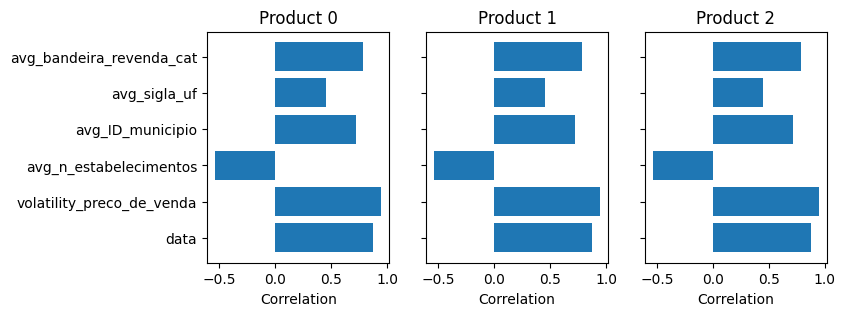

In [26]:
fig = plt.figure(dpi = 100, figsize = (8, 3))
gs = fig.add_gridspec(1, 3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].barh(look_0.index, look_0.values)
axs[0].set_title('Product 0')
axs[0].set_xlabel('Correlation')

axs[1].barh(look_1.index, look_0.values)
axs[1].set_title('Product 1')
axs[1].set_xlabel('Correlation')

axs[2].barh(look_2.index, look_0.values)
axs[2].set_title('Product 2')
axs[2].set_xlabel('Correlation')

We can see that the correlations are very similar to each other!

Getting data as the index to predict:

In [27]:
df_0.index = pd.to_datetime(df_0['data'], format='%Y-%m-%d')
df_1.index = pd.to_datetime(df_1['data'], format='%Y-%m-%d')
df_2.index = pd.to_datetime(df_2['data'], format='%Y-%m-%d')
del df_0['data']
del df_1['data']
del df_2['data']

Taking a look at the average selling price per product:

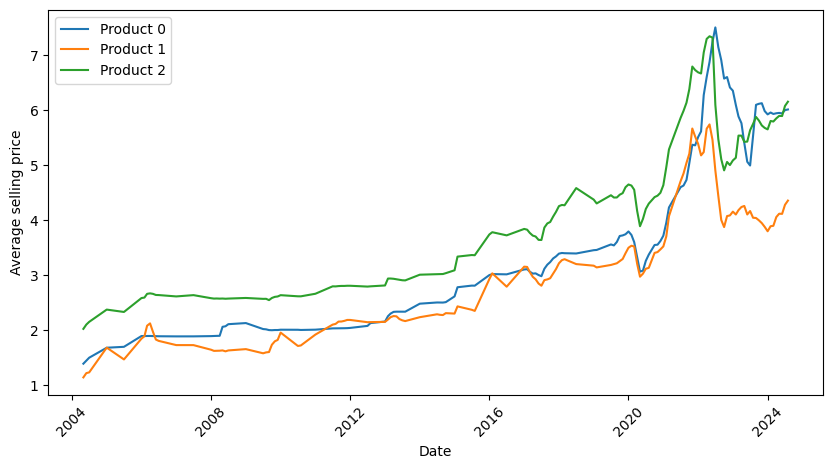

In [28]:
plt.figure(dpi = 100, figsize = (10, 5))
plt.ylabel('Average selling price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.plot(df_0.index, df_0['avg_preco_venda'], label = 'Product 0')
plt.plot(df_1.index, df_1['avg_preco_venda'], label = 'Product 1')
plt.plot(df_2.index, df_2['avg_preco_venda'], label = 'Product 2')
plt.legend()

## 4) Starting the models

Let's split the data into training and testing sets for each product:

In [29]:
train_0 = df_0[df_0.index < pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test_0 = df_0[df_0.index > pd.to_datetime("2022-12-01", format='%Y-%m-%d')]

train_1 = df_1[df_1.index < pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test_1 = df_1[df_1.index > pd.to_datetime("2022-12-01", format='%Y-%m-%d')]

train_2 = df_2[df_2.index < pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test_2 = df_2[df_2.index > pd.to_datetime("2022-12-01", format='%Y-%m-%d')]

In [30]:
train_0.shape, test_0.shape, train_1.shape, test_1.shape, train_2.shape, test_2.shape

((117, 6), (20, 6), (117, 6), (20, 6), (117, 6), (20, 6))

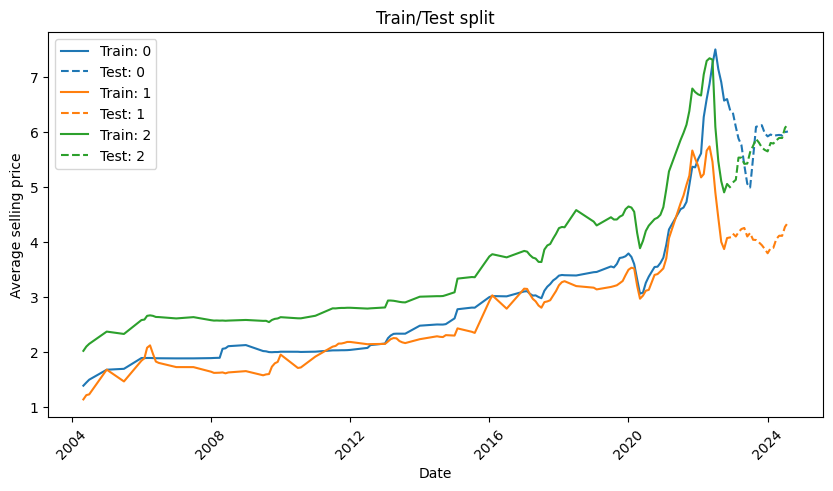

In [31]:
plt.figure(dpi = 100, figsize = (10, 5))

plt.plot(train_0['avg_preco_venda'], color = "C0", label = 'Train: 0')
plt.plot(test_0['avg_preco_venda'], color = "C0", ls = '--', label = 'Test: 0')

plt.plot(train_1['avg_preco_venda'], color = "C1", label = 'Train: 1')
plt.plot(test_1['avg_preco_venda'], color = "C1", ls = '--', label = 'Test: 1')

plt.plot(train_2['avg_preco_venda'], color = "C2", label = 'Train: 2')
plt.plot(test_2['avg_preco_venda'], color = "C2", ls = '--', label = 'Test: 2')

plt.ylabel('Average selling price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title("Train/Test split")
plt.legend()

Now let's split between y and x:

In [32]:
y_train_0 = train_0['avg_preco_venda']
exog_train_0 = np.array([ train_0['volatility_preco_de_venda'], train_0['avg_n_estabelecimentos'], 
                          train_0['avg_ID_municipio'], train_0['avg_sigla_uf'], train_0['avg_bandeira_revenda_cat'] ]).T

y_train_1 = train_1['avg_preco_venda']
exog_train_1 = np.array([ train_1['volatility_preco_de_venda'], train_1['avg_n_estabelecimentos'], 
                          train_1['avg_ID_municipio'], train_1['avg_sigla_uf'], train_1['avg_bandeira_revenda_cat'] ]).T

y_train_2 = train_2['avg_preco_venda']
exog_train_2 = np.array([ train_2['volatility_preco_de_venda'], train_2['avg_n_estabelecimentos'], 
                          train_2['avg_ID_municipio'], train_2['avg_sigla_uf'], train_2['avg_bandeira_revenda_cat'] ]).T

y_test_0 = test_0['avg_preco_venda']
exog_test_0 = np.array([ test_0['volatility_preco_de_venda'], test_0['avg_n_estabelecimentos'], 
                      test_0['avg_ID_municipio'], test_0['avg_sigla_uf'], test_0['avg_bandeira_revenda_cat'] ]).T

y_test_0 = test_0['avg_preco_venda']
exog_test_0 = np.array([ test_0['volatility_preco_de_venda'], test_0['avg_n_estabelecimentos'], 
                      test_0['avg_ID_municipio'], test_0['avg_sigla_uf'], test_0['avg_bandeira_revenda_cat'] ]).T

y_test_1 = test_1['avg_preco_venda']
exog_test_1 = np.array([ test_1['volatility_preco_de_venda'], test_1['avg_n_estabelecimentos'], 
                      test_1['avg_ID_municipio'], test_1['avg_sigla_uf'], test_1['avg_bandeira_revenda_cat'] ]).T

y_test_2 = test_2['avg_preco_venda']
exog_test_2 = np.array([ test_2['volatility_preco_de_venda'], test_2['avg_n_estabelecimentos'], 
                      test_2['avg_ID_municipio'], test_2['avg_sigla_uf'], test_2['avg_bandeira_revenda_cat'] ]).T


Let's predict the optimal order for ARIMA model using `auto_arima`:

In [33]:
model_0 = auto_arima(y_train_0, X = exog_train_0, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=88.707, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=136.759, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=98.848, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=109.918, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=134.864, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=90.214, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=130.548, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=98.204, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=97.694, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=95.673, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=98.966, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=89.238, Time=0.11 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=97.714, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=73.178, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=97.379, Time=0.

In [34]:
model_1 = auto_arima(y_train_1, X = exog_train_1, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-104.772, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.334, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.565, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-105.828, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.507, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-110.660, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-106.889, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.970, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-110.421, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-105.279, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-111.308, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-111.451, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-110.599, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-106.036, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]            

In [35]:
model_2 = auto_arima(y_train_2, X = exog_train_2, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=33.849, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=121.880, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27.451, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=69.254, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=119.990, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=24.497, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=31.536, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=409.017, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=30.182, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=33.517, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=27.409, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.732 seconds


Now, instantiating and training the models:

In [46]:
ARIMA_model_0 = ARIMA(y_train_0, exog_train_0, order = (1, 0, 1))
ARIMA_model_0 = ARIMA_model_0.fit()
y_pred_0 = ARIMA_model_0.predict(start = train_0.shape[0], end = train_0.shape[0] + test_0.shape[0] - 1, exog = exog_test_0)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

In [47]:
ARIMA_model_1 = ARIMA(y_train_1, exog_train_1, order = (1, 1, 0))
ARIMA_model_1 = ARIMA_model_1.fit()
y_pred_1 = ARIMA_model_1.predict(start = train_1.shape[0], end = train_1.shape[0] + test_1.shape[0] - 1, exog = exog_test_1)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 

In [48]:
ARIMA_model_2 = ARIMA(y_train_2, exog_train_2, order = (2, 0, 0))
ARIMA_model_2 = ARIMA_model_2.fit()
y_pred_2 = ARIMA_model_2.predict(start = train_2.shape[0], end = train_2.shape[0] + test_2.shape[0] - 1, exog = exog_test_2)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

Visualizing the results:

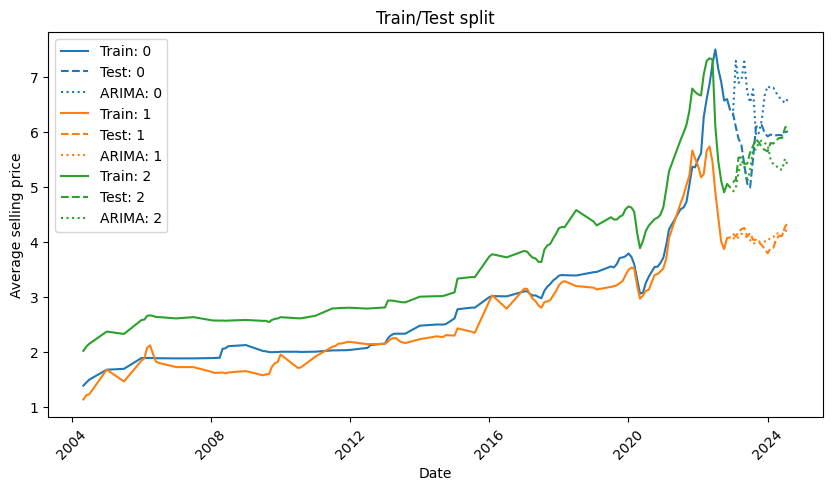

In [49]:
plt.figure(dpi = 100, figsize = (10, 5))

plt.plot(train_0['avg_preco_venda'], color = "C0", label = 'Train: 0')
plt.plot(test_0['avg_preco_venda'], color = "C0", ls = '--', label = 'Test: 0')
plt.plot(test_0.index, y_pred_0.values, color='C0', ls = ':', label = 'ARIMA: 0')

plt.plot(train_1['avg_preco_venda'], color = "C1", label = 'Train: 1')
plt.plot(test_1['avg_preco_venda'], color = "C1", ls = '--', label = 'Test: 1')
plt.plot(test_1.index, y_pred_1.values, color='C1', ls = ':', label = 'ARIMA: 1')

plt.plot(train_2['avg_preco_venda'], color = "C2", label = 'Train: 2')
plt.plot(test_2['avg_preco_venda'], color = "C2", ls = '--', label = 'Test: 2')
plt.plot(test_2.index, y_pred_2.values, color='C2', ls = ':', label = 'ARIMA: 2')

plt.ylabel('Average selling price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title("Train/Test split")
plt.legend()

## 5) Evaluating the model

In [50]:
#Printing metrics - product 0
print("Model metrics - product 0")
print("RMSE: ", np.sqrt(mean_squared_error(y_pred_0, test_0['avg_preco_venda'])))
print("MAPE: ", mean_absolute_percentage_error(y_pred_0, test_0['avg_preco_venda']))
print("MAE : ", mean_absolute_error(y_pred_0, test_0['avg_preco_venda']))

Model metrics - product 0
RMSE:  0.976724553991905
MAPE:  0.12284580052691585
MAE :  0.8361503143868134


In [51]:
#Printing metrics - product 1
print("Model metrics - product 1")
print("RMSE: ", np.sqrt(mean_squared_error(y_pred_1, test_1['avg_preco_venda'])))
print("MAPE: ", mean_absolute_percentage_error(y_pred_1, test_1['avg_preco_venda']))
print("MAE : ", mean_absolute_error(y_pred_1, test_1['avg_preco_venda']))

Model metrics - product 1
RMSE:  0.11319609834872399
MAPE:  0.023509273302429235
MAE :  0.09608281271380403


In [52]:
#Printing metrics - product 2
print("Model metrics - product 2")
print("RMSE: ", np.sqrt(mean_squared_error(y_pred_2, test_2['avg_preco_venda'])))
print("MAPE: ", mean_absolute_percentage_error(y_pred_2, test_2['avg_preco_venda']))
print("MAE : ", mean_absolute_error(y_pred_2, test_2['avg_preco_venda']))

Model metrics - product 2
RMSE:  0.3485316664309747
MAPE:  0.05170834804832153
MAE :  0.2781744604945526


The average price for June, July, and August are:

In [53]:
print('Product 0: ', y_pred_0.values[-3], y_pred_0.values[-2], y_pred_0.values[-1])

Product 0:  6.581591106370752 6.529164468168279 6.6072461130174736


In [54]:
print('Product 1: ', y_pred_1.values[-3], y_pred_1.values[-2], y_pred_1.values[-1])

Product 1:  4.142060470427645 4.219784637362022 4.193207145326475


In [55]:
print('Product 2: ', y_pred_2.values[-3], y_pred_2.values[-2], y_pred_2.values[-1])

Product 2:  5.319923670138998 5.516049877450372 5.3941315584424805
